In [103]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import scipy.spatial as spatial
from scipy.spatial import Voronoi, voronoi_plot_2d, cKDTree
from scipy.spatial.distance import cdist

path_base = "./IMG/"

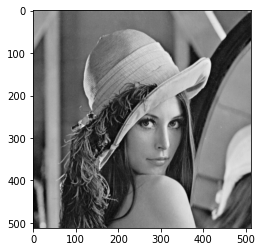

In [104]:
lena = cv2.imread(path_base + "lena_gray_512.tif", 0)
plt.imshow(lena, "gray")

In [105]:
def LBG_2D(input_vectors, N):
  codebook_vectors = np.random.rand(N, 2)
  codebook = dict(list(enumerate(codebook_vectors)))

  display_voronoi_diagram(codebook_vectors, input_vectors)
  LBG_2D_R(codebook, input_vectors, N)

def LBG_2D_R(codebook, input_vectors, N):
  codebook_vectors = list(codebook.values())
  new_codebook_vectors = compute_new_vectors_2d(codebook_vectors, input_vectors)
  display_voronoi_diagram(new_codebook_vectors, input_vectors)
  print(distorsion(codebook_vectors, new_codebook_vectors))

  new_codebook = dict(list(enumerate(new_codebook_vectors)))

  if distorsion(codebook_vectors, new_codebook_vectors) > 1e-8:
    return LBG_2D_R(new_codebook, input_vectors, N)
  else:
    return new_codebook

def display_voronoi_diagram(codebook_vectors, input_vectors):
  vor = Voronoi(codebook_vectors)

  fig,ax = plt.subplots(1,1,figsize=(5,5))
  voronoi_plot_2d(vor, ax, show_vertices = False)
  plt.scatter(input_vectors[:,0], input_vectors[:,1],color = 'r')

def compute_new_vectors_2d(codebook_vectors,input_vectors):
  voronoi_kdtree = cKDTree(codebook_vectors)
  input_vectors_dist, input_vectors_regions = voronoi_kdtree.query(input_vectors)

  new_codebook_vectors = np.zeros((N,2))

  for i in range(N):
    indexes = np.where(input_vectors_regions==i)
    current_region_vectors = [input_vectors[idx] for idx in indexes][0]
    if len(current_region_vectors) > 0:
      avg = np.mean(current_region_vectors, axis=0)
      new_codebook_vectors[i] = avg
    else:
      new_codebook_vectors[i] = codebook_vectors[i]

  return new_codebook_vectors

def distorsion(old_vectors, new_vectors):
  #return np.square(np.subtract(old_vectors, new_vectors)).mean() #Mean Squared Error
  return np.sqrt(np.sum(np.square(old_vectors - new_vectors))) #Distance euclidienne


0.29278447230459953
0.13468733662994356
0.08261481132041865
0.044137556050465175
0.0


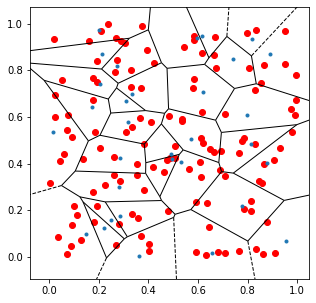

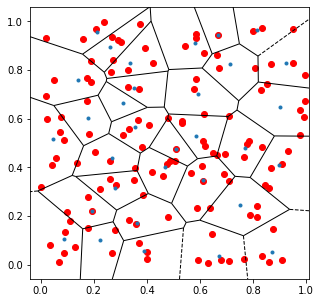

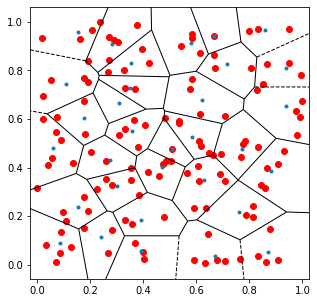

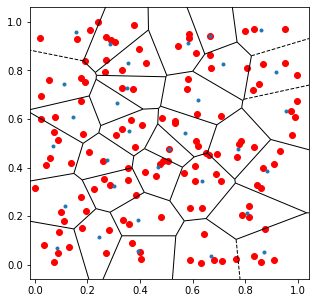

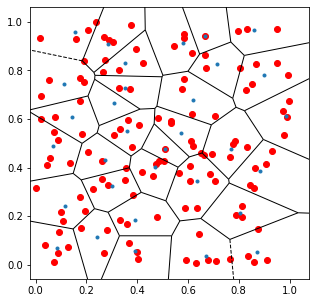

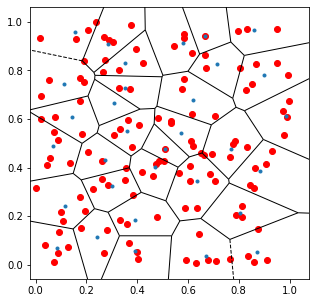

In [106]:
vectors = np.random.rand(128, 2)
N = 32

LBG_2D(vectors, N)

In [107]:
def LBG_img(img, N, block_size):
  vect_dim = block_size[0] * block_size[1]
  input_vectors = extract_input_vectors(img, block_size)
  codebook_vectors = np.random.rand(N, vect_dim) * 255
  codebook = dict(list(enumerate(codebook_vectors)))

  return LBG_img_R(codebook, input_vectors, N, vect_dim)

def LBG_img_R(codebook, input_vectors, N, vect_dim):
  codebook_vectors = list(codebook.values())
  new_codebook_vectors = compute_new_vectors_img(codebook_vectors, input_vectors, vect_dim)
  print(distorsion(codebook_vectors, new_codebook_vectors))
  new_codebook = dict(list(enumerate(new_codebook_vectors)))

  if distorsion(codebook_vectors, new_codebook_vectors) > 1e-8:
    return LBG_img_R(new_codebook, input_vectors, N, vect_dim)
  else:
    return new_codebook

def compute_new_vectors_img(codebook_vectors,input_vectors, vect_dim):
  voronoi_kdtree = cKDTree(codebook_vectors)
  input_vectors_dist, input_vectors_regions = voronoi_kdtree.query(input_vectors)
  new_codebook_vectors = np.zeros((N,vect_dim))

  for i in range(N):
    indexes = np.where(input_vectors_regions==i)
    current_region_vectors = [input_vectors[idx] for idx in indexes[0]]
    if len(current_region_vectors) > 0:
      avg = np.mean(current_region_vectors, axis=0)
      new_codebook_vectors[i] = avg
    else:
      new_codebook_vectors[i] = codebook_vectors[i]

  return new_codebook_vectors

def extract_input_vectors(arr, block_size):
    nrows, ncols = block_size
    h, w = arr.shape
    assert h % nrows == 0, f"{h} rows is not evenly divisible by {nrows}"
    assert w % ncols == 0, f"{w} cols is not evenly divisible by {ncols}"
    blocks = arr.reshape(h//nrows, nrows, -1, ncols).swapaxes(1,2).reshape(-1, nrows, ncols)
    vectors = [block.flatten() for block in blocks]
    return vectors

In [108]:
N = 16
block_size = (2,2)

codebook_lena = LBG_img(lena, N, block_size) #Optimized codebook

236.32378220562697
85.97770278606077
36.449645539377386
24.0875490303492
21.573089387514898
13.895802331409751
9.599574648235908
9.87215850268049
8.51770416840764
6.567298754616878
5.160139576210464
4.296027129626075
3.2448918267972107
2.934933838141684
3.1959949573675863
2.6731824675393026
2.8978728882338523
3.147394969608146
2.99390469676157
3.0546437331949337
3.1937800421536133
3.246121528722956
3.169336627807929
2.9156521820791035
2.885716416050463
3.006522339873012
2.5576498240940473
2.557925217105658
2.9461502837261313
3.348334062774251
3.5305192704753825
3.410579963446506
5.054979766716091
5.801059144652567
5.000006276774181
5.762964178206227
5.53858609789192
5.130097739689666
4.9151638937569695
4.879777300140968
3.921613589675995
3.7723180194414665
3.1739573928536835
2.983478821352999
2.112564896379143
1.686972034648903
1.7333500688199137
1.6224430521691373
1.9215377196180474
1.3648466154108385
1.1456208085499313
1.1264007301615988
1.0489308162090358
1.1549885840212777
1.222162

In [109]:
def encode(img, codebook):
  vect_dim = len(list(codebook.values())[0])
  nblock = int(np.sqrt(vect_dim))
  block_size = (nblock, nblock)
  input_vectors = extract_input_vectors(img,block_size)

  all_distances = min_distance(input_vectors, codebook)

  rows, cols = img.shape
  img_encoded = np.reshape([np.argmin(distances) for distances in all_distances], (int(rows/nblock), int(cols/nblock)))
  return img_encoded

def min_distance(input_vector, codebook):
  codebook_vectors = list(codebook.values())
  return cdist(input_vector, codebook_vectors)
  
lena_encoded = encode(lena, codebook_lena)

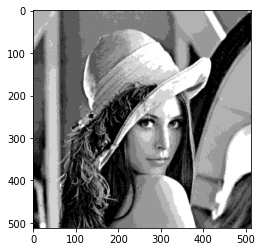

In [121]:
def decode(encoded_img, codebook):
  vect_dim = len(list(codebook.values())[0])
  nblock = int(np.sqrt(vect_dim))
  block_size = (nblock, nblock)

  blocks = []
  rows, cols = encoded_img.shape

  for i in range(rows):
    for j in range(cols):
      block = codebook[encoded_img[i,j]].reshape(block_size)
      blocks.append(np.array(block))

  decoded_img = reconstruct_image(np.array(blocks), (rows*nblock, cols*nblock))
  return decoded_img

def reconstruct_image(arr, block_size):
    h, w = block_size
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

lena_decoded = decode(lena_encoded, codebook_lena)
plt.imshow(lena_decoded, "gray")

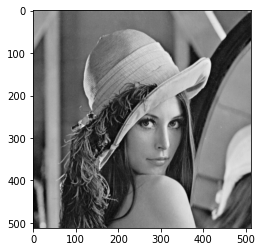

In [122]:
plt.imshow(lena, "gray")